# Tutorial 8 - LDA & QDA
Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) are a generative model , in which we can learn the model's parameters by maximizing the joint likelihood 

${\displaystyle P(x,y)=P(x\mid y ) P(y ) }$

In LDA, in basic set up, y has two values, which means 2 classes. We assume
that each class draws from normal distribution:
${\displaystyle (x\mid y=0 )=\mathcal{N}(\mu_0,\,\Sigma) }$

${\displaystyle (x\mid y=1 )=\mathcal{N}(\mu_1,\,\Sigma) }$

The are two option:

1. Linear Discriminant Analysis (LDA) - assumes   and  are different means of 2 normal distributions, and  is shared covariance matrix.

2. Quadratic Discriminant Analysis (QDA) -assumes   and  are different means of 2 normal distributions, and  is not shared covariance matrix.



Example 1: Different mean - Shared Covariance 

In [1]:
!pip install nilearn 



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
C = np.array([[0.0, -0.23], [0.83, 0.23]])
C

array([[ 0.  , -0.23],
       [ 0.83,  0.23]])

### functions

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)

<ipython-input-3-6b074e35e9cc>:13: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.cm.register_cmap(cmap=cmap)


In [4]:
import numpy as np


def dataset_fixed_cov():
    """Generate 2 Gaussians samples with the same covariance matrix"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -0.23], [0.83, 0.23]])
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C) + np.array([1, 1]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    """Generate 2 Gaussians samples with different covariance matrices"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -1.0], [2.5, 0.7]]) * 2.0
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

In [5]:
from scipy import linalg


def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
        plt.ylabel("Data with\n fixed covariance")
    elif fig_index == 2:
        plt.title("Quadratic Discriminant Analysis")
    elif fig_index == 3:
        plt.ylabel("Data with\n varying covariances")

    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")

### LDA & QDA examples

<ipython-input-5-3b1c92b0caf9>:69: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(
<ipython-input-5-3b1c92b0caf9>:69: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(
<ipython-input-5-3b1c92b0caf9>:69: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(
<ipython-input-5-3b1c92b0caf9>:69: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(


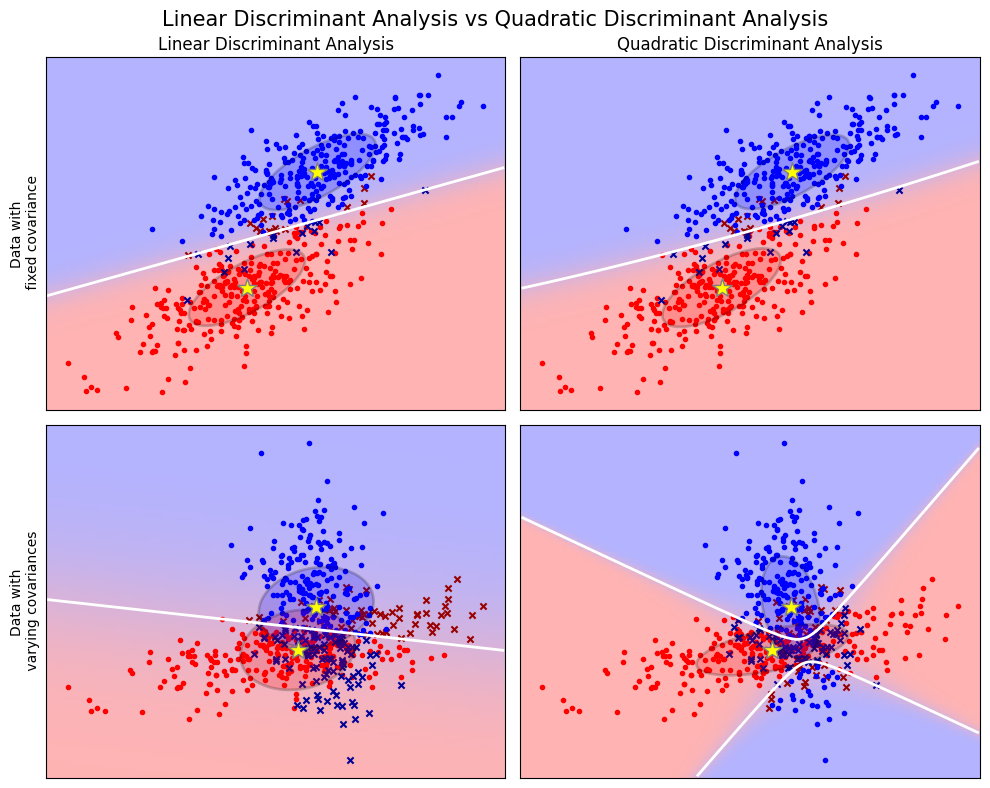

In [6]:
plt.figure(figsize=(10, 8), facecolor="white")
plt.suptitle(
    "Linear Discriminant Analysis vs Quadratic Discriminant Analysis",
    y=0.98,
    fontsize=15,
)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis("tight")

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis("tight")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

## LDA & QDA - fMRI data

In [7]:
import os
from nilearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
haxby_dataset = datasets.fetch_haxby(data_dir='/content',subjects= 3, fetch_stimuli=True )

Downloaded 256974848 of 314803244 bytes (81.6%,    0.9s remaining) ...done. (5 seconds, 0 min)
Extracting data from /content/haxby2001/1c647aaa0929f6a1e99884fbb3929600/subj1-2010.01.14.tar.gz..... done.


Downloaded 222658560 of 296936090 bytes (75.0%,    1.0s remaining) ...done. (4 seconds, 0 min)
Extracting data from /content/haxby2001/1c647aaa0929f6a1e99884fbb3929600/subj3-2010.01.14.tar.gz..... done.


In [34]:
from nilearn.input_data import NiftiMasker
mask_filename = haxby_dataset.mask_vt[0]
func_file = haxby_dataset.func[0]
masker = NiftiMasker(mask_img=mask_filename, standardize=True, detrend=True)
# Selecting data
fmri_data = masker.fit_transform(func_file)


behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
condition = behavioral["labels"]
print(condition.unique())

['rest' 'scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle'
 'chair']


In [52]:
label = ['face', 'house','cat','shoe' ] #['face', 'house','cat' ,'shoe', 'scrambledpix' ,'bottle','chair']
mask =  condition.isin(label)
X = fmri_data[mask]

y = condition[mask]

print(X.shape)
print(y.shape)


(432, 577)
(432,)


In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis ,QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score ,cross_val_predict
from sklearn.model_selection import LeaveOneOut  
from IPython.display import clear_output

In [53]:
## Linear Discriminant Analysis
cv = LeaveOneOut()
LDA = LinearDiscriminantAnalysis()
scores_lda = cross_val_score(LDA, X, y, cv=cv)

score_mean_lda = np.mean(scores_lda)
print(f'The score value: {score_mean_lda}' )


predicted_lda = cross_val_predict(LDA, X, y, cv=cv)
output_lda = np.stack((y , predicted_lda),axis= 1)
pd.DataFrame(output_lda, columns=["True Label", "Predict Label"])

The score value: 0.9490740740740741


,True Label,Predict Label
0,face,face
1,face,face
2,face,face
3,face,face
4,face,face
...,...,...
427,cat,cat
428,cat,cat
429,cat,face
430,cat,cat


In [54]:
## Quadratic Discriminant Analysis
QDA = QuadraticDiscriminantAnalysis()
scores_qda = cross_val_score(QDA, X, y, cv=cv)
predicted_qda = cross_val_predict(QDA, X, y, cv=cv)


score_mean_qda = np.mean(scores_qda)
print(f'The score value: {score_mean_qda}' )

output_qda = np.stack((y , predicted_qda),axis= 1)
pd.DataFrame(output_qda, columns=["True Label", "Predict Label"])


The score value: 0.375


,True Label,Predict Label
0,face,house
1,face,cat
2,face,cat
3,face,cat
4,face,face
...,...,...
427,cat,cat
428,cat,house
429,cat,cat
430,cat,house


<Axes: >

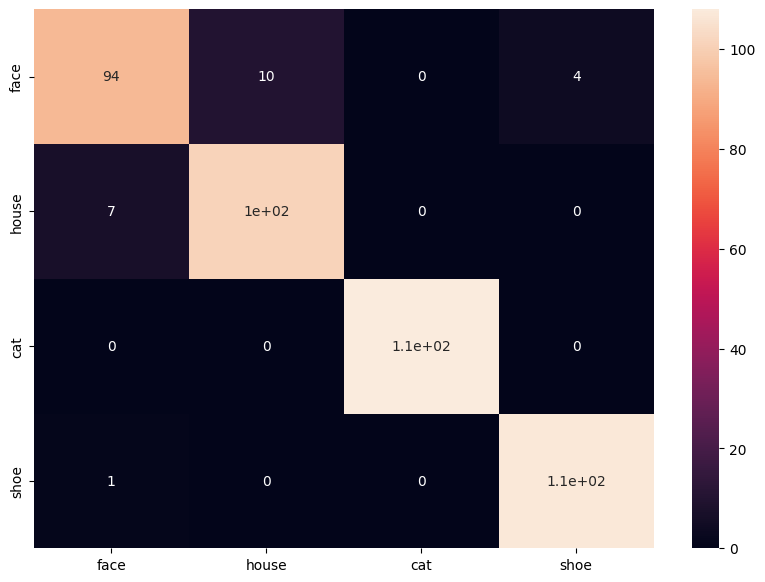

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm_lda = confusion_matrix(y, predicted_lda)
df_cm = pd.DataFrame(cm_lda, index =label,
                  columns = label)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)



<Axes: >

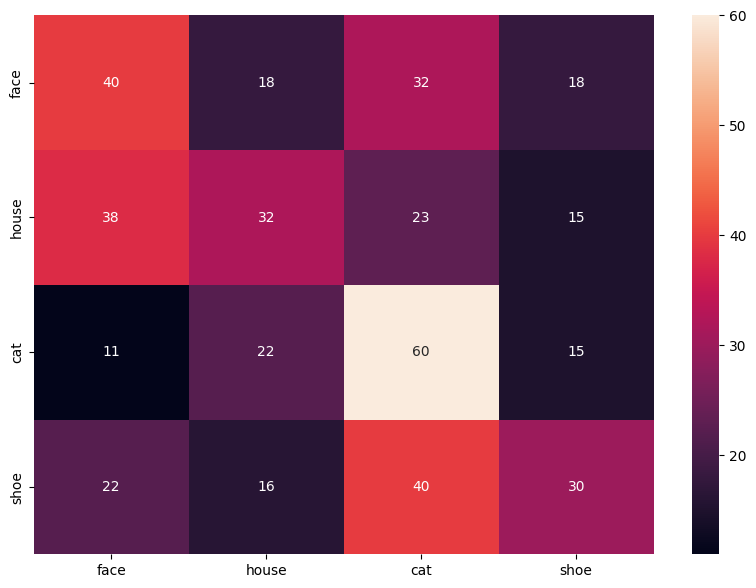

In [56]:
cm_qda = confusion_matrix(y, predicted_qda)
df_cm = pd.DataFrame(cm_qda, index =label,
                  columns = label)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)